## Access Wave Buoy Realtime Nonqc (Parquet)

This Jupyter notebook demonstrates how to access and plot wave buoy realtime nonqc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/b299cdcd-3dee-48aa-abdd-e0fcdbb9cadc).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/wave_buoy_realtime_nonqc.ipynb).


In [1]:
dataset_name = "wave_buoy_realtime_nonqc"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 36ms


✅ Local version 0.2.3 is up to date (remote: 0.2.2)


In [3]:
from DataQuery import GetAodn

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:2956: UserWarning: registration of accessor <class 'DataQuery.AODNAccessor'> under name 'aodn' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("aodn")


# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 83.2 ms, sys: 17.7 ms, total: 101 ms
Wall time: 6.7 s


In [5]:
aodn_dataset.dataset.partitioning.schema

site_name: string
timestamp: int32
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('site_name')
print(list(unique_partition_value)[0:5])  # showing a subset only

['Albany', 'Indented%20Head', 'Lakes%20Entrance', 'Rottnest%20Island', 'Cottesloe']
CPU times: user 13.5 ms, sys: 6.4 ms, total: 19.9 ms
Wall time: 14.9 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


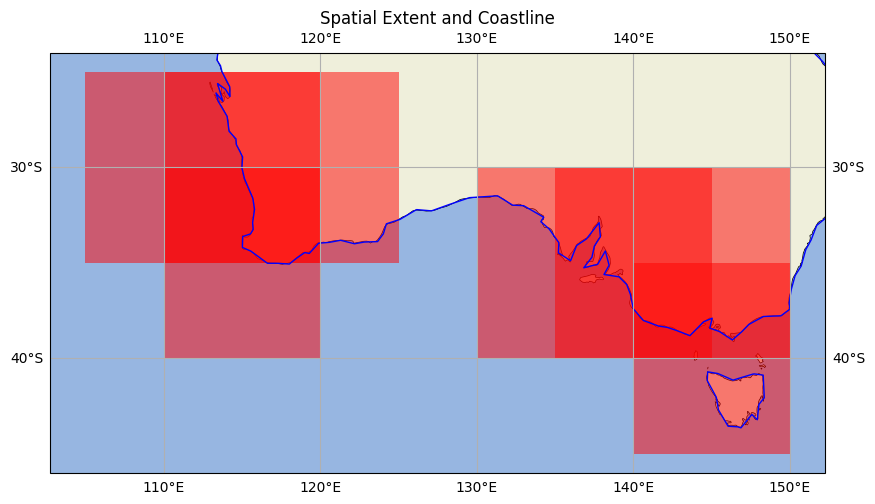

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('2022-09-01 00:02:01'), Timestamp('2024-07-30 07:31:31'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-16 15:31:22,895 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/wave_buoy_realtime_nonqc.parquet
2025-06-16 15:31:23,011 - aodn.GetAodn - WARNING - Old 'dataset_metadata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'timeSeries': {'type': 'int32',
  'long_name': 'unique identifier for each feature instance',
  'cf_role': 'timeseries_id'},
 'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 90000.0},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'reference_datum': 'WGS84 coordinate reference system; EPSG:4326'},
 'LONGITUDE': {'type': 'double',
  'standard_name': 'longitude',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180.0,
  'valid_max': 180.0,
  'reference_datum': 'WGS84 coordinate reference system; EPSG:4326'},
 'WHTH': {'type': 'double',
  'standard_name': 'sea_surface_wave_significant_height',
  'long_name': 'sea surface wave significant height from time domain analysis',
  'units': 'm',
  'valid_min': 0.0,
  'valid_max': 100.0,
  'method

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [10]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-01', date_end='2023-01-01',lat_min=-40, lat_max=-20, lon_min=140, lon_max=160)
df.info()

2025-06-16 15:31:23,788 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/wave_buoy_realtime_nonqc.parquet
2025-06-16 15:31:23,906 - aodn.GetAodn - WARNING - Old 'dataset_metadata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timeSeries            14835 non-null  int32         
 1   TIME                  14835 non-null  datetime64[ns]
 2   LATITUDE              14835 non-null  float64       
 3   LONGITUDE             14835 non-null  float64       
 4   WHTH                  0 non-null      float64       
 5   WPMH                  0 non-null      float64       
 6   WMXH                  0 non-null      float64       
 7   WPPE                  14835 non-null  float64       
 8   WPDI                  14835 non-null  float64       
 9   WPDS                  14835 non-null  float64       
 10  WAVE_quality_control  14835 non-null  float32       
 11  water_depth           14835 non-null  int64         
 12  wmo_id                0 non-null      object        
 13  filename        

In [11]:
# Download subsetted data as CSV
df.aodn.download_as_csv()

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_b299cdcd-3dee-48aa-abdd-e0fcdbb9cadc_unknown_data-hash_69ead719.csv.zip

## Create a TIME and scalar/number filter

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = aodn_dataset.get_data( date_start='2020-07-12', date_end='2023-02-05', scalar_filter= {'site_name': 'Cottesloe'})
df.info()

2025-06-16 15:31:24,341 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/wave_buoy_realtime_nonqc.parquet
2025-06-16 15:31:24,458 - aodn.GetAodn - WARNING - Old 'dataset_metadata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timeSeries            211 non-null    int32         
 1   TIME                  211 non-null    datetime64[ns]
 2   LATITUDE              211 non-null    float64       
 3   LONGITUDE             211 non-null    float64       
 4   WHTH                  211 non-null    float64       
 5   WPMH                  211 non-null    float64       
 6   WMXH                  211 non-null    float64       
 7   WPPE                  211 non-null    float64       
 8   WPDI                  211 non-null    float64       
 9   WPDS                  211 non-null    float64       
 10  WAVE_quality_control  211 non-null    float32       
 11  water_depth           211 non-null    int64         
 12  wmo_id                211 non-null    object        
 13  filename            

<Axes: xlabel='TIME', ylabel='sea_surface_wave_significant_height'>

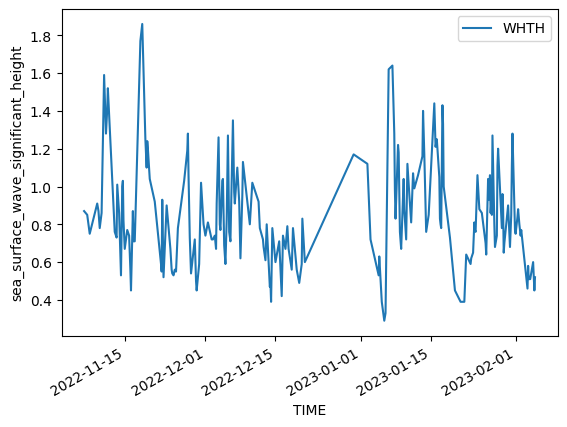

In [13]:
df[df['WAVE_quality_control'] == 2].sort_values('TIME').plot(x='TIME', 
                                                             y='WHTH', 
                                                             kind='line', 
                                                             ylabel=metadata['WHTH']['standard_name'])